В задании используется база курса акций Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


## Подготовка данных

**Загрузка библиотек**

На этом этапе настраивается рабочее окружение и подключаются необходимые библиотеки:

1. Визуализация графиков в ноутбуке - команда %matplotlib inline позволяет отображать графики прямо в ячейках.

2. Отключение предупреждений - используется модуль warnings, чтобы скрыть лишние сообщения и сделать вывод чище.

3. Работа с данными -  импортируются NumPy и Pandas для работы с массивами и таблицами, а также gdown для загрузки данных из Google Drive.

4. Визуализация - matplotlib.pyplot используется для построения графиков и отображения результатов.

5. Нейросети (Keras + TensorFlow) - импортируются модели (Sequential, Model), слои (Dense, LSTM, Conv1D и др.), и оптимизатор Adam для построения и обучения нейросетей.

Генерация обучающих последовательностей
TimeseriesGenerator создает выборки из временных рядов для обучения.

Масштабирование данных
MinMaxScaler и StandardScaler нормализуют данные для повышения эффективности обучения.

In [ ]:
# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings

# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Model, Sequential

# Основные слои
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    LSTM,
    concatenate,
)

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore')

**Настройка внешнего вида графиков**

В этом блоке задаются параметры отображения графиков по умолчанию для более наглядной визуализации:

1. Импорт rcParams из pylab - используется для настройки параметров графиков, таких как размер и шрифт.

2. Установка стиля ggplot - стиль оформления графиков похож на популярный стиль из R. Он делает графики более читаемыми и визуально приятными.

3. Назначение размера графиков - все графики по умолчанию будут отображаться в размере 14×7 дюймов, что обеспечивает хорошую видимость данных даже при длинных временных рядах.


In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

# Загрузка базы

На этом этапе происходит загрузка исходных данных:

- Использование gdown
С помощью функции gdown.download() файл CSV загружается по прямой ссылке из облачного хранилища.

In [ ]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)

'16_17.csv'

Далее загруженный CSV-файл читается в табличную структуру:

- Использование pandas.read_csv
Функция читает содержимое файла 16_17.csv и сохраняет его в переменную base_data в виде DataFrame.

- Параметр sep=';'
Указывает, что в файле используется точка с запятой в качестве разделителя колонок (формат CSV может использовать как запятую, так и ;).

In [ ]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('16_17.csv', sep=';')

Затем выполняется вызов base_data.head().
Эта команда выводит первые 5 строк DataFrame base_data.

In [ ]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


**Очистка данных**

Происходит чтение CSV-файла - файл 16_17.csv снова загружается в DataFrame, но теперь результат сохраняется в переменную data16_17.

И удаление ненужных столбцов с помощью .drop(columns=['DATE', 'TIME']) из таблицы удаляются столбцы DATE и TIME, так как для прогнозирования временного ряда по ценам акций они не нужны.

In [ ]:
# Загрузка датасетов с удалением ненужных столбцов по дате и времени

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])

Далее выполняется вызов print(data16_17.shape).
Эта команда выводит кортеж с числом строк и столбцов в таблице data16_17.

In [ ]:
# Просмотр размерностей получившихся таблицы

print(data16_17.shape)

(263925, 5)


**Извлечение базовой информации о данных**

В данном блоке происходит:

1. Переименование переменной - d = data16_17 — для краткости создаётся копия основного DataFrame под именем d.

2. Вывод количества строк - d.shape[0] показывает общее число записей (наблюдений) в таблице — т.е. длину временного ряда.

3. Вывод количества столбцов - d.shape[1] отображает количество признаков (характеристик) в каждой записи.

4. Просмотр первой строки данных - d.iloc[0] выводит содержимое первой строки (нулевой индекс), что помогает увидеть реальные значения признаков и их формат.

In [ ]:
# Пример данных одного датасета
d = data16_17

print(d.shape[0])  # Всего записей (строк)
print(d.shape[1])  # Количество столбцов
print(d.iloc[0])   # Пример нулевой строки данных

263925
5
OPEN      2351.0
MAX       2355.8
MIN       2350.0
CLOSE     2350.0
VOLUME    2547.0
Name: 0, dtype: float64


**Преобразование данных в массив NumPy**

В данном блоке происходит:

1. Преобразование DataFrame в массив - команда pd.concat([data16_17]) объединяет один DataFrame (в данном случае это просто способ получить копию) и сразу преобразует его в массив NumPy с помощью .to_numpy().

2. Результат сохраняется в переменную data.

In [ ]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17]).to_numpy()

**Просмотр размерности новой таблицы**

- Вывод размеров исходного DataFrame - print(data16_17.shape) показывает количество строк и столбцов исходной таблицы Pandas.

- Вывод размеров массива NumPy - print(data.shape) показывает форму массива после преобразования из DataFrame.

In [ ]:
# Просмотр размерности новой таблицы

print(data16_17.shape)
print(data.shape)

(263925, 5)
(263925, 5)


**Задание текстовых меток каналов данных (столбцов)**

Здесь выполняется создание списка названий столбцов. Переменная channel_names содержит имена признаков в данных: Open, Max, Min, Close, Volume.

In [ ]:
# Задание текстовых меток каналов данных (столбцов)

channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume']

**Иллюстрация данных в графическом виде**

В данном блоке происходит:

1. Задание диапазона для отображения - параметры start и length определяют участок временного ряда, который будет отрисован.

2. Создание полотна с графиками - используется plt.subplots с одной осью x и двумя подграфиками.

3. Отрисовка основных каналов (Open, Max, Min, Close) - для каждого из первых четырёх признаков (chn от 0 до 3) рисуется линия, соответствующая ценам на выбранном участке.

4. Подписи и оформление.

5. Отображение графика - команда plt.show() выводит итоговое изображение.

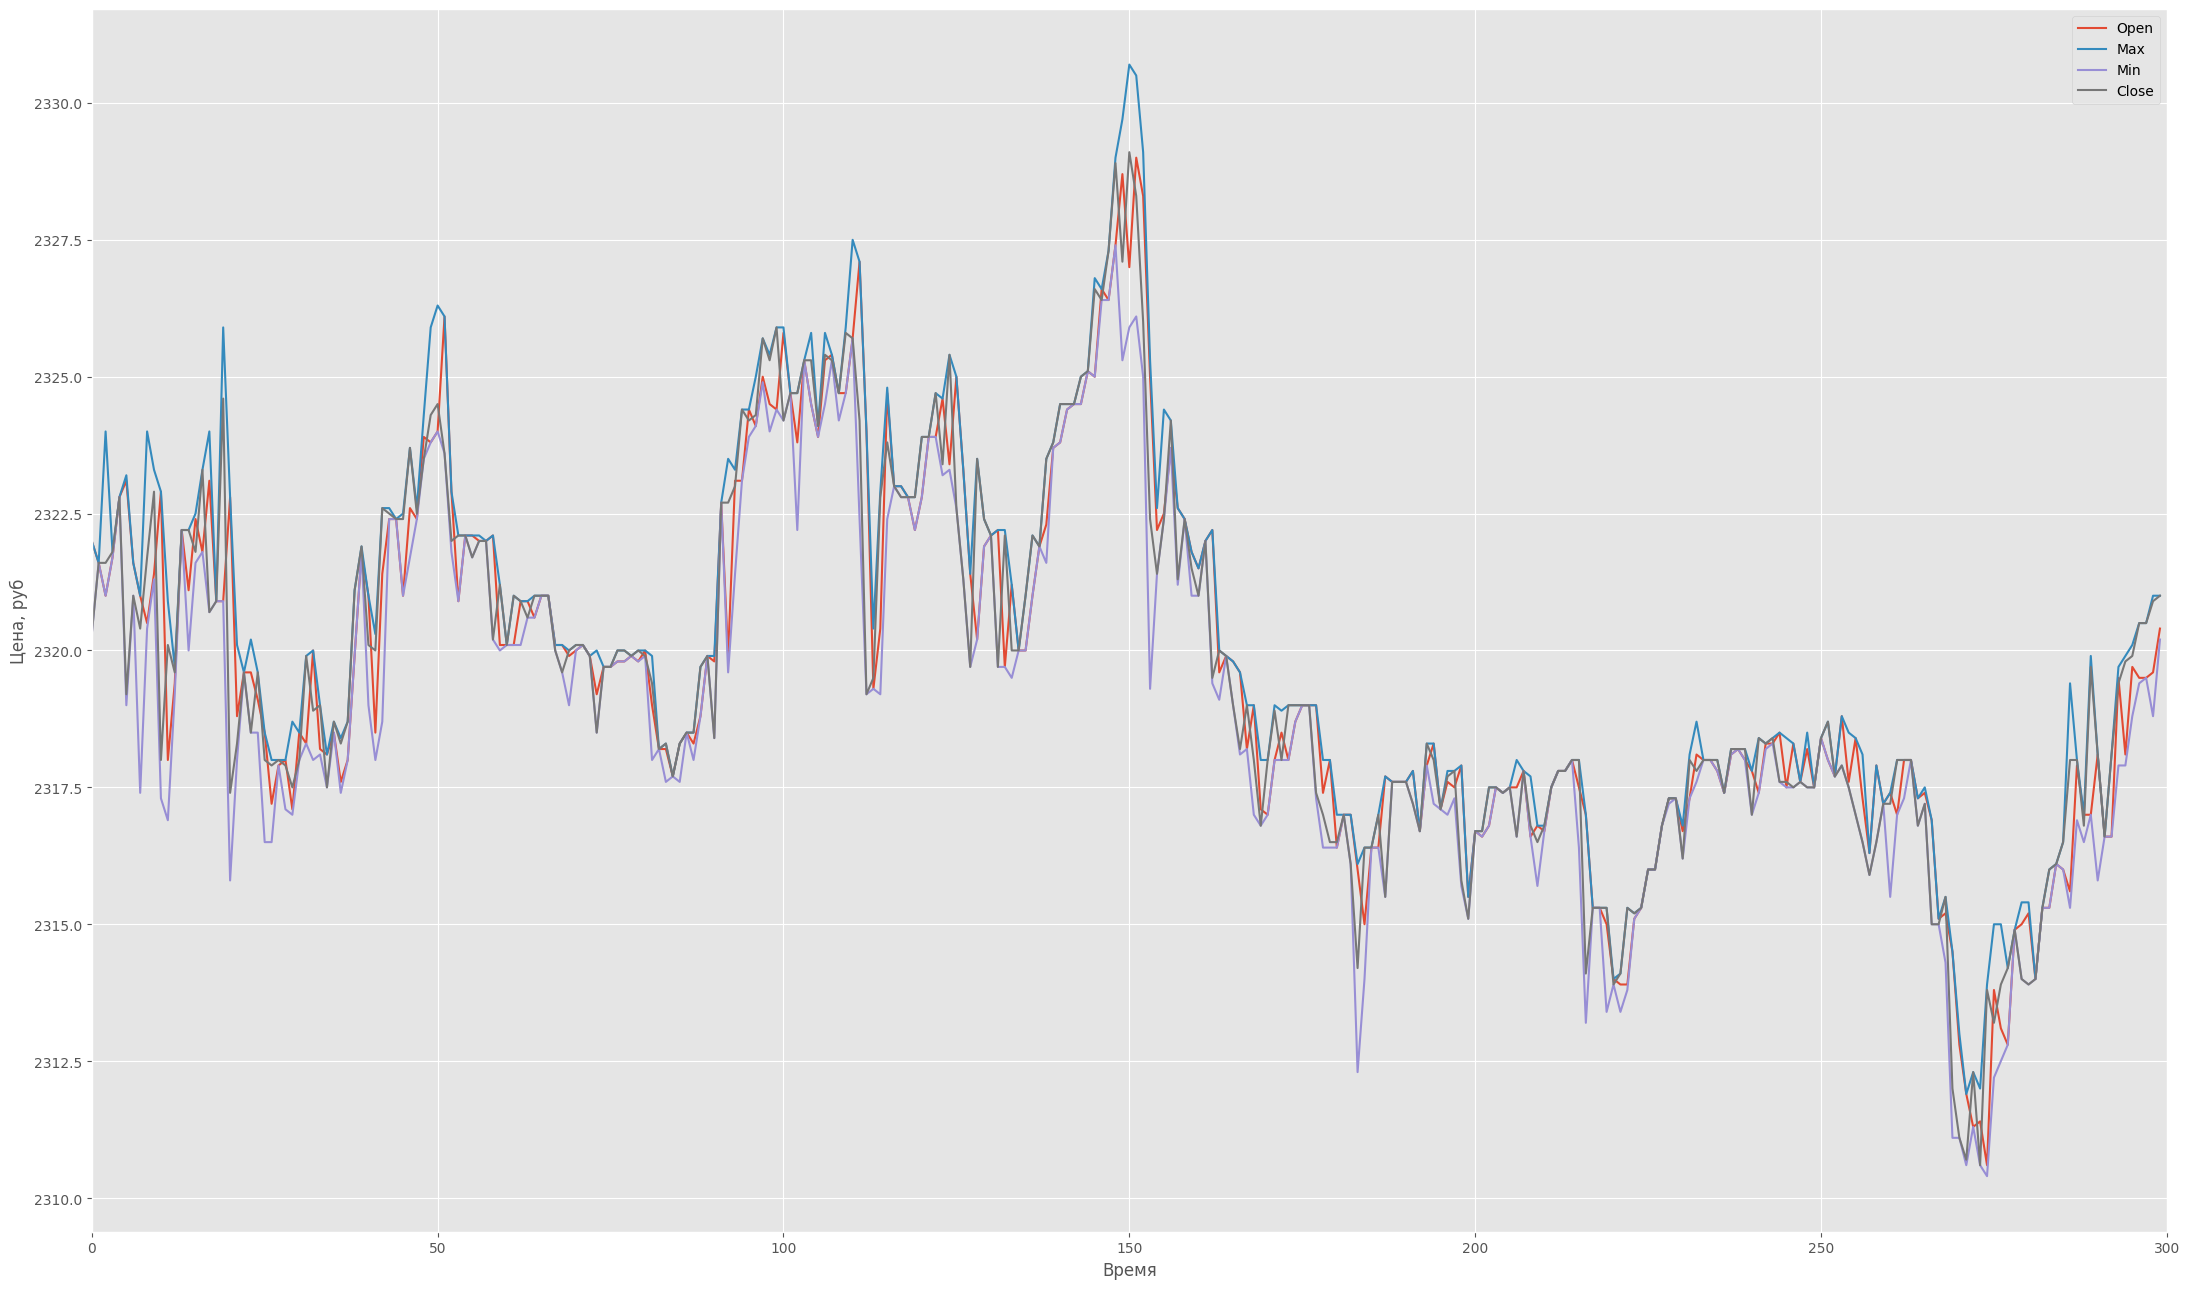

In [ ]:
# Отображение исходных данных от точки start и длинной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, ax = plt.subplots(figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax.plot(data[start:start + length, chn],
             label=channel_names[chn])
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')

# Регулировка пределов оси x
plt.xlim(0, length)

# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()

# Фиксация графика
plt.show()

**Создание словаря для индексов каналов**

В данном блоке происходит:

1. Определение списка названий каналов - CHANNEL_NAMES — список с именами признаков: 'Open', 'Max', 'Min', 'Close', 'Volume'.

2. Создание словаря соответствия - CHANNEL_INDEX — словарь, где ключ — название канала, а значение — его порядковый индекс (позиция в списке).
Используется генератор словаря с enumerate, который автоматически нумерует элементы.

3. Вывод словаря - print показывает полученное отображение, например:
{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


**Задание гиперпараметров для обучения**

В данном блоке задаются:

1. Выбор входных и выходных каналов
- CHANNEL_X — список признаков, используемых как входные данные для модели (все каналы: Open, Max, Min, Close, Volume).

- CHANNEL_Y — целевой канал для предсказания, в данном случае только Close (цена закрытия).

2. Длина последовательности для анализа - SEQ_LEN = 300 — длина окна временного ряда, которую модель будет использовать для предсказания.

3. Размер батча - BATCH_SIZE = 20 — количество образцов, которые модель обрабатывает за один шаг обучения.

4. Размер тестовой и обучающей выборок

- TEST_LEN = 30000 — количество наблюдений, выделенных под тестирование.

- TRAIN_LEN = data.shape[0] - TEST_LEN — оставшаяся часть данных идёт на обучение.

In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

# Подготовка данных для обучения и создание генераторов

В данном блоке выполняется формирование списков индексов каналов:

- chn_x — индексы входных признаков (входные каналы для модели).

- chn_y — индексы целевых признаков для предсказания.

Разделение данных на обучающую и тестовую выборки:

- Обучающая часть — первые TRAIN_LEN строк.

- Тестовая — начиная с TRAIN_LEN + 2*SEQ_LEN (зазор в 2*SEQ_LEN для предотвращения пересечения окон).

Выделение входных и выходных данных:

- Входные данные берутся по индексам из chn_x.

- Выходные — по chn_y.

Масштабирование:

- Используется MinMaxScaler для нормализации значений в диапазон [0, 1].

- Скейлер обучается на тренировочных данных, затем применяется и к тестовым.

Выполняется проверка формы полученных массивов - проверяется, что размеры соответствуют ожиданиям (число строк, количество признаков).

Создание генераторов временных рядов:

- TimeseriesGenerator формирует батчи из последовательностей длины SEQ_LEN для обучения и валидации.

Параметры:

- length=SEQ_LEN — длина входного окна.

- stride=1 — шаг окна.

- batch_size=BATCH_SIZE.

И также выполняется проверка формы батча от генератора - выводятся размеры входных и выходных данных из первого батча для контроля.



In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (233925, 5), (233925, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (20, 300, 5), y: (20, 1)


**Создание генератора для тестовой выборки**

В данной блоке были выполнены следующие действия:
1. Инициализация генератора test_datagen - генератор формирует последовательности длиной SEQ_LEN из тестовых данных.

2. Извлечение полного тестового набора - x_test, y_test = test_datagen[0] — получение первого (и единственного) батча из генератора, который содержит всю тестовую выборку.

3. Проверка формы массива - вывод размеров тестовых входных и целевых данных для уверенности в корректности.

In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (29100, 300, 5), y: (29100, 1)


# Сервесные функции
**Функция расчета результата прогнозирования сети (предсказания)**

Входные параметры:

- model — обученная нейросеть.

- x_test, y_test — тестовые данные (входы и правильные ответы).

- y_scaler — объект масштабирования для целевой переменной (обычно MinMaxScaler).

В данный функции происходит:
1. Вычисление предсказаний - модель предсказывает выходы на основе x_test.

2. Денормализация предсказаний - используется y_scaler.inverse_transform для перевода предсказанных значений из нормализованного диапазона обратно в исходные единицы измерения.

3. Денормализация правильных ответов - аналогично преобразуются истинные значения y_test для удобства сравнения.

4. Возврат результата - функция возвращает два массива — предсказания и истинные значения в исходном масштабе.

In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

**Функция визуализации результата предсказания сети и верных ответов**

Параметры функции:

- y_pred, y_true — массивы предсказанных и настоящих значений.

- start — индекс начальной точки временного ряда для визуализации.

- length — количество точек для отображения на графике.

- chn_list — список каналов для отрисовки (если не задан, рисуются все).

- chn_names — имена каналов (по умолчанию CHANNEL_Y).

- title — заголовок графика.

В данный функции происходит:
1. Выбор каналов для отображения - если chn_list пуст, функция автоматически строит графики для всех доступных каналов.

2. Построение графика, оформление графика и тображение графика - команда plt.show() выводит график.

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

**Функция рисования корреляций прогнозного ряда и исходного со смещением**

Параметры функции:

- y_pred, y_true — массивы прогнозных и реальных значений.

- back_steps_max — максимальное число шагов смещения назад по времени для анализа корреляции (по умолчанию 30).

- chn_list — список каналов для анализа (если не задан, берутся все).

- chn_names — имена каналов.

- title — заголовок графика.

В данный функции происходит:
1. Подготовка - определяется длина временного ряда и создаётся диапазон сдвигов от 0 до back_steps_max.

2. Вычисление корреляций - для каждого канала вычисляются кросс-корреляция между истинными данными и прогнозом с разным сдвигом. И автокорреляция истинных данных (как эталон).

3. Построение графика - для каждого канала на одном графике выводятся линии кросс-корреляции и автокорреляции.

In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

**Функция расчета корреляционного коэффициента Пирсона для двух рядов**

Функция correlate(a, b) вычисляет корреляцию Пирсона между двумя одномерными массивами a и b.

Используется np.corrcoef(a, b) — матрица корреляций, из которой берётся элемент [0, 1], отражающий корреляцию между a и b. Возвращаемое значение будет
коэффициент корреляции (число от -1 до 1).

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

**Функция визуализации результата работы сети**

Входные параметры:

- model — обученная модель.

- x_test, y_test — тестовые данные (вход и правильные ответы).

- y_scaler — нормировщик целевой переменной.

- start, length — параметры для отображения графиков (начальная точка и длина отрезка).

- back_steps_max — максимальное число шагов смещения для корреляции.

- title — заголовок для графиков.

В данный функции происходит:
1. Получение предсказаний - вызов get_pred для получения денормализованных предсказаний и истинных данных.

2. Визуализация сопоставления рядов - график сравнения предсказанных и истинных значений сдвинут на 1 шаг назад, т.к. предсказание — на следующий шаг.

3. Визуализация корреляций - построение графика корреляционных коэффициентов между предсказанием и истинным рядом с разными сдвигами.



In [ ]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

**Функция обучения модели и отрисовки прогресса и оценки результатов**

Входные параметры:

- model — нейросеть для обучения.

- train_datagen, val_datagen — генераторы для обучающей и валидационной выборок.

- epoch_list — список фаз обучения, где каждая фаза задаётся кортежем (число эпох, оптимизатор).

- x_test, y_test — тестовые данные для оценки.

- y_scaler — нормировщик для обратного преобразования целевых данных.

- start, length, back_steps_max, title — параметры для визуализации.

В данный функции происходит:
1. Процесс обучения - выводится сводка модели (model.summary()).

2. Для каждой фазы - компилируется модель с указанным оптимизатором и функцией потерь MSE.

3. Модель обучается заданное число эпох.

4. Строится график динамики ошибки обучения и проверки по эпохам.

5. Оценка после каждой фазы - вызывается функция eval_net для визуализации качества предсказаний модели на тесте — графики сравнения и корреляций.



In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

# Создание и обучение простой полносвязной сети

Архитектура модели:

- Входной слой — Dense с 32 нейронами и активацией ReLU, принимает входную форму (SEQ_LEN, количество каналов).

- Flatten — преобразует 2D-данные в одномерный вектор.

- Выходной слой — Dense с количеством нейронов, равным числу каналов для предсказания (Close), с линейной активацией.

Обучение:

- Модель обучается на 10 эпох с оптимизатором Adam и очень маленьким шагом обучения (1e-6).

- Используются заранее созданные генераторы train_datagen и val_datagen.

- По окончании обучения автоматически строятся графики ошибок и оценки модели.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         9,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,793 (38.25 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 10 эпох
Epoch 1/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0215 - val_loss: 1.1031e-04
Epoch 2/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 1.2159e-04 - val_loss: 9.2120e-05
Epoch 3/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 1.0791e-04 - val_loss: 7.6630e-05
Epoch 4/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 9.4204e-05 - val_loss: 8.2844e-05
Epoch 5/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 8.2885e-05 - val_loss: 6.3144e-05
Epoch 6/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 7.2456e-05 - val_loss: 5.8775e-05
Epoch 7/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 6.8018e-05 - val_loss: 5.1192e-05
Epoch 8/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 6.0629e-05 - val_loss: 8.1360e-05
Epoch 9/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 5.8278e-05 - val_loss: 5.2334e-05
Epoch 10/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 5.3892e-05 - val_loss: 4.4964e

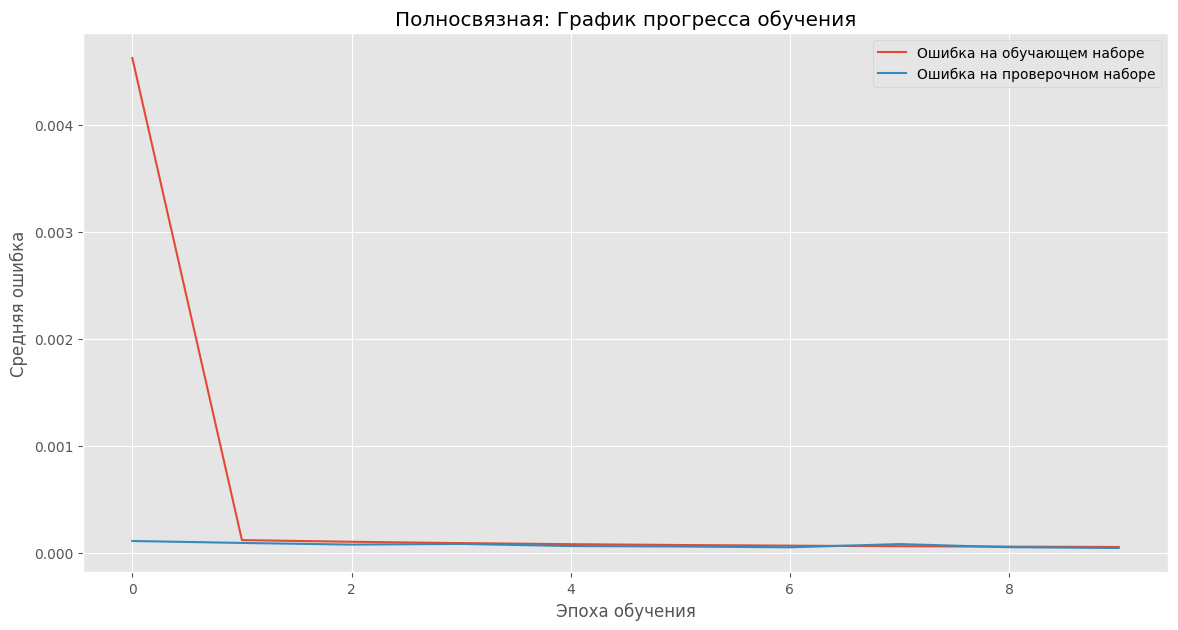

910/910 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


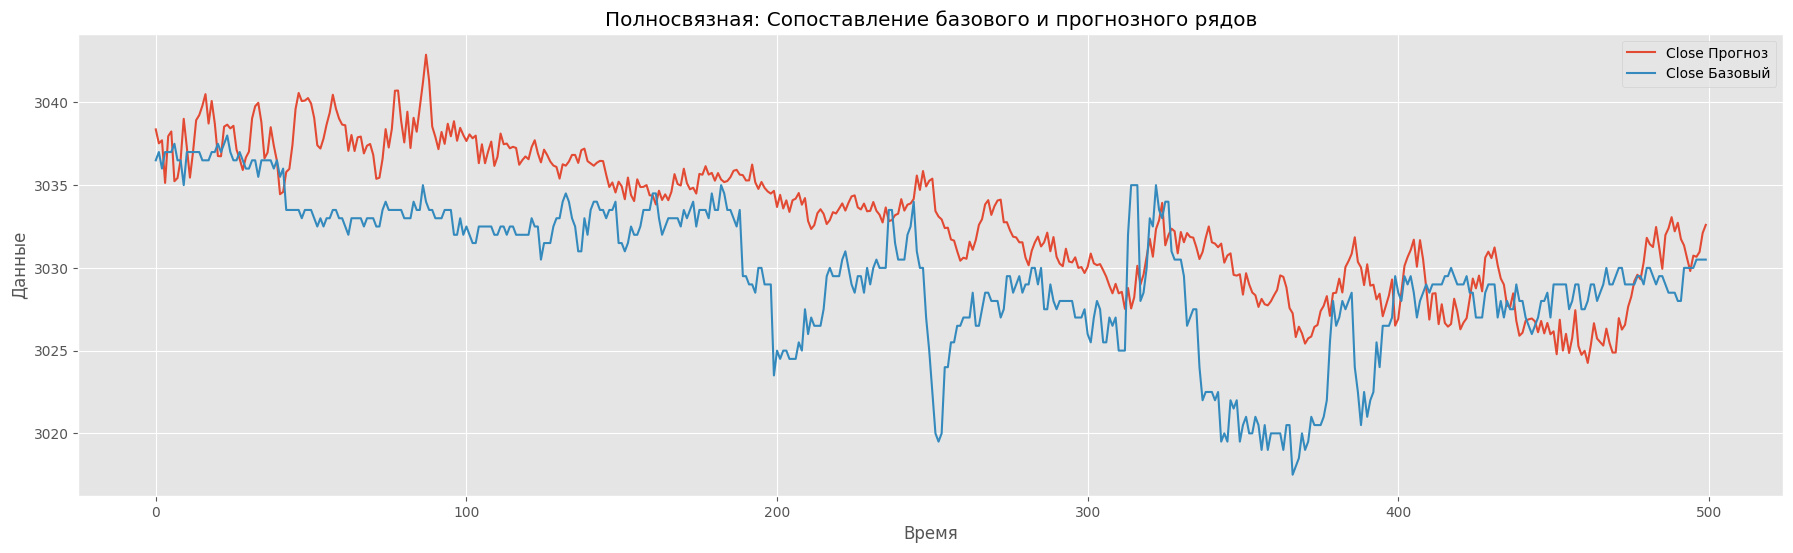

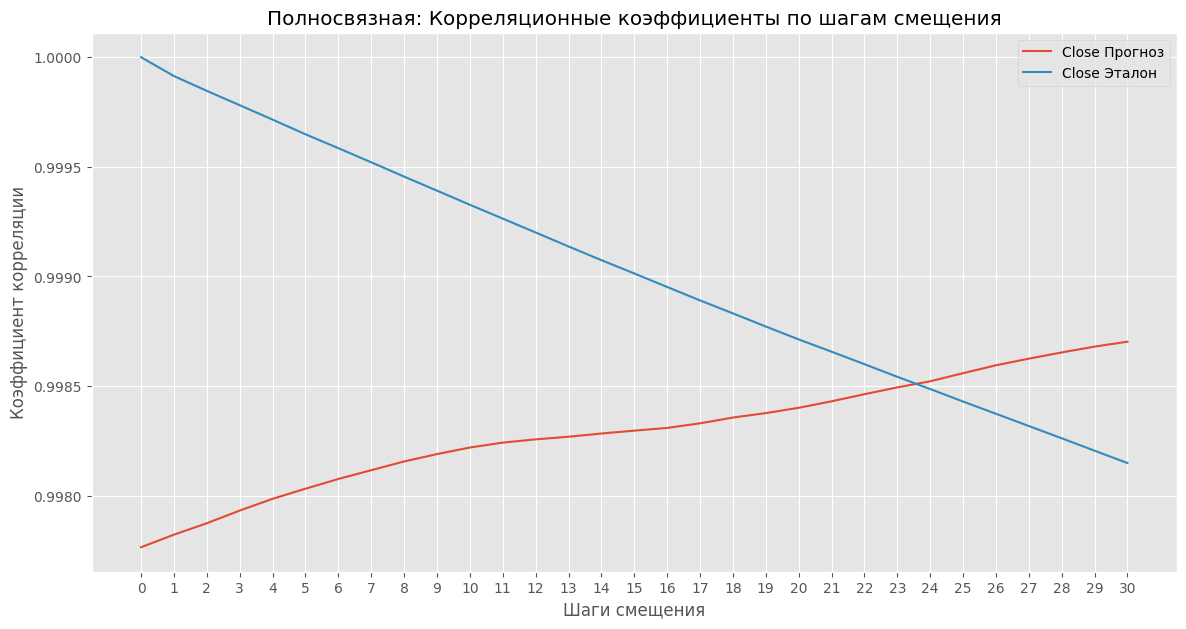

In [ ]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(32, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 10 эпох для ускорения
train_eval_net(model_dense, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-6))],
               x_test, y_test, y_scaler, title='Полносвязная')

# Подготовка данных идля обучения той же модель, но для 10 шагов вперед.

Параметр - FORECAST_STEPS = 10 — количество шагов, которые модель должна предсказывать вперёд.

Функция prepare_multi_step_y:

- Принимает массив целевых данных y_data, длину входной последовательности seq_len и количество шагов предсказания forecast_steps.

- Создаёт массив, где для каждой позиции i формируется последовательность из forecast_steps точек, следующих сразу после входной последовательности длины seq_len.

- Возвращает numpy-массив размерности (число последовательностей, forecast_steps, количество каналов).

In [ ]:
# Параметры
FORECAST_STEPS = 10  # Количество шагов предсказания вперед

# Подготовка y_data для многошагового предсказания
def prepare_multi_step_y(y_data, seq_len, forecast_steps):
    y_sequences = []
    for i in range(len(y_data) - seq_len - forecast_steps + 1):
        y_sequences.append(y_data[i+seq_len : i+seq_len+forecast_steps])
    return np.array(y_sequences)

**Подготовка данных и генераторов для многошагового прогноза**

В данном блоку выполняется:
1. Горизонт прогноза - FORECAST_STEPS = 10 — количество шагов вперёд, которые модель будет прогнозировать.

2. Подготовка выходных данных - с помощью функции prepare_multi_step_y формируются последовательности целевых значений длиной 10 шагов для обучения (y_train_multi) и теста (y_test_multi).

3. Обрезка входных данных - входные данные x_train_multi и x_test_multi подгоняются под длину новых выходных последовательностей.

4. Генераторы - создаются генераторы временных рядов для обучения и валидации (train_datagen_multi, val_datagen_multi) с новым форматом данных. Генератор для теста test_datagen_multi формирует батчи для оценки.

5. Проверка - выводятся формы данных батча: вход X — (batch_size, seq_len, features), выход Y — (batch_size, forecast_steps, targets).

6. Выводятся размеры полных тестовых массивов.

In [ ]:
# Параметры для многошагового прогноза
FORECAST_STEPS = 10  # горизонт прогноза (количество шагов вперед)

# Формирование выходных последовательностей из y (функция уже определена в ноутбуке)
y_train_multi = prepare_multi_step_y(y_data_train, SEQ_LEN, FORECAST_STEPS)
y_test_multi  = prepare_multi_step_y(y_data_test,  SEQ_LEN, FORECAST_STEPS)

# Обрезка x_data до длины, соответствующей новым y_multi
x_train_multi = x_data_train[:len(y_train_multi)]
x_test_multi  = x_data_test[:len(y_test_multi)]

# Создаем генераторы временных рядов для обучения и проверки (batch_size как в базовом примере)
train_datagen_multi = TimeseriesGenerator(x_train_multi, y_train_multi, length=SEQ_LEN, batch_size=BATCH_SIZE)
val_datagen_multi   = TimeseriesGenerator(x_test_multi,  y_test_multi,  length=SEQ_LEN, batch_size=BATCH_SIZE)

# Проверяем форму данных из генератора
x_batch, y_batch = train_datagen_multi[0]

print(f"Shape of batch X: {x_batch.shape}, Y: {y_batch.shape}")
# Ожидаемый вывод: X: (BATCH_SIZE, SEQ_LEN, num_features), Y: (BATCH_SIZE, FORECAST_STEPS, num_targets)

# Создаем генератор тестовых данных для многошагового прогноза
test_datagen_multi = TimeseriesGenerator(
    x_test_multi,
    y_test_multi,
    length=SEQ_LEN,        # длина последовательности (должна совпадать с SEQ_LEN)
    stride=1,
    sampling_rate=1,
    batch_size=BATCH_SIZE  # размер батча (должен совпадать с BATCH_SIZE)
)

# Формирование тестовой выборки из генератора
x_test_full, y_test_full = test_datagen_multi[0]

# Проверка формы тестовой выборки
print(f'Test x (multi-step): {x_test_multi.shape}, y (multi-step): {y_test_multi.shape}')

Shape of batch X: (20, 300, 5), Y: (20, 10, 1)
Test x (multi-step): (29091, 5), y (multi-step): (29091, 10, 1)


# Построение простой полносвязной модели для прогноза 10 шагов вперед

Архитектура модели:

- Входной слой Dense с 32 нейронами и активацией ReLU, принимает последовательность формы (SEQ_LEN, количество признаков).

- Flatten — преобразует 2D-последовательность в одномерный вектор.

- Выходной слой Dense с числом нейронов равным FORECAST_STEPS (10), линейная активация для предсказания значений сразу на 10 шагов вперед.

Компиляция:

- Используется оптимизатор Adam с очень маленьким шагом обучения 1e-6.

- Функция потерь — среднеквадратичная ошибка (MSE).

Метод summary() отображает структуру и количество параметров модели.

In [ ]:
# Построение простой полносвязной модели для прогноза 10 шагов вперед
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(SEQ_LEN, x_train_multi.shape[1])))
model.add(Flatten())
model.add(Dense(FORECAST_STEPS, activation='linear'))

model.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        96,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,202 (375.79 KB)

 Trainable params: 96,202 (375.79 KB)

 Non-trainable params: 0 (0.00 B)

**Обучение модели**

- Используется генератор train_datagen_multi с батчами данных.

- Для проверки качества на каждом шаге обучения используется валидационный генератор val_datagen_multi.

- Обучение проводится в течение 10 эпох.

- verbose=1 — подробный вывод процесса обучения.

In [ ]:
# Обучение модели в течение 10 эпох
history = model.fit(
    train_datagen_multi,
    validation_data=val_datagen_multi,
    epochs=10,
    verbose=1
)

Epoch 1/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0751 - val_loss: 4.4151e-04
Epoch 2/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 5.4369e-04 - val_loss: 4.1995e-04
Epoch 3/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 5.5633e-04 - val_loss: 5.7705e-04
Epoch 4/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 5.2653e-04 - val_loss: 6.0124e-04
Epoch 5/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 5.3510e-04 - val_loss: 4.8329e-04
Epoch 6/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 5.0031e-04 - val_loss: 4.2258e-04
Epoch 7/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 5.1129e-04 - val_loss: 3.9882e-04
Epoch 8/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 5.0049e-04 - val_loss: 4.5278e-04
Epoch 9/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 4.9697e-04 - val_loss: 3.8030e-04
Epoch 10/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 5.0528e-04 - val_loss: 4.1709e-04


**Визуализация результатов**

С помощью функции get_pred получаем денормализованные предсказания y_pred и истинные значения y_true на тестовой выборке.

Отрисовка графика сравнения - визуализируем прогноз и оригинальный временной ряд на одном графике с помощью функции show_predict. Для многошагового прогноза отображаются сразу все шаги вперёд без сдвига.

Корреляционный анализ - строим график корреляционных коэффициентов между прогнозом и эталоном по разным сдвигам во времени с помощью функции show_corr.

910/910 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


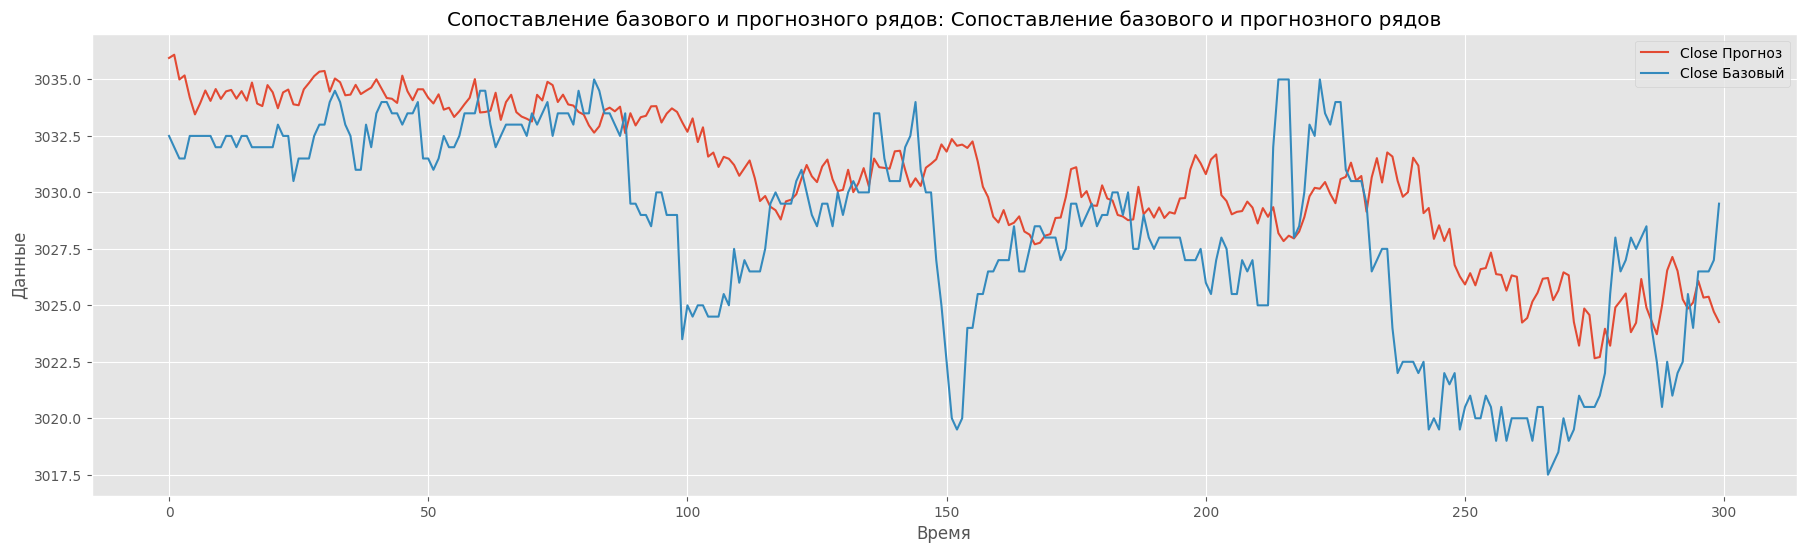

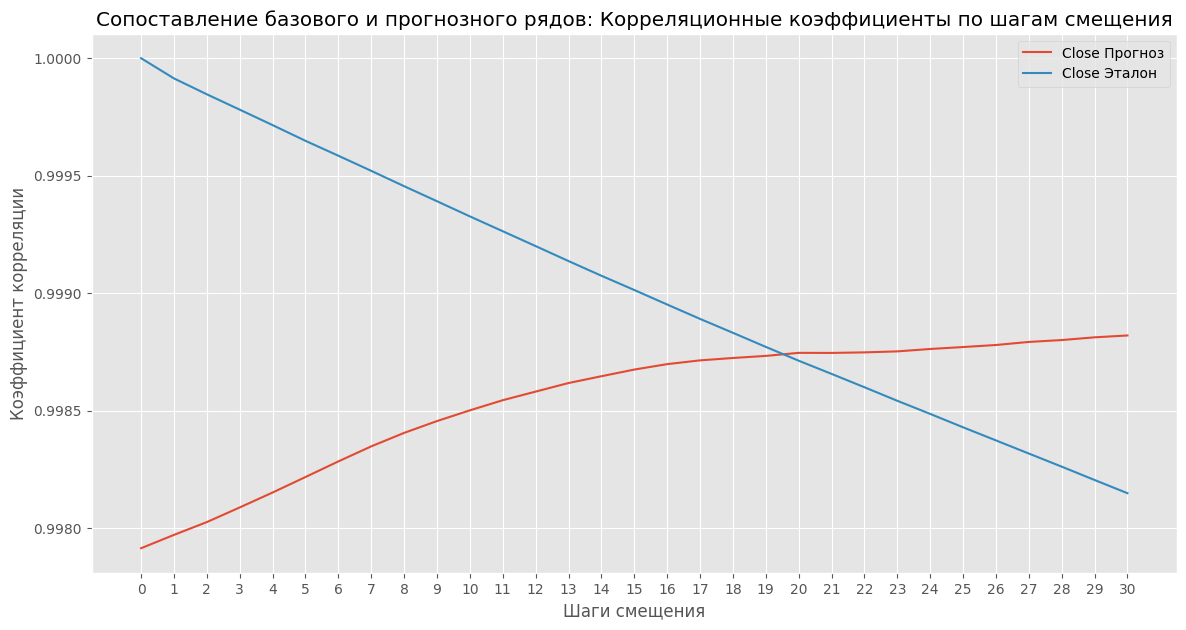

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
# Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
title = 'Сопоставление базового и прогнозного рядов'
show_predict(y_pred[1:], y_true[:-1], start, length, title=f'{title}: Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, back_steps_max=30, title=f'{title}: Корреляционные коэффициенты по шагам смещения')

**Получение предсказаний**

- Получаем предсказания модели на тестовой выборке в нормализованном виде (y_pred_scaled) с формой (число примеров, 10 шагов вперёд).

- Для обратного масштабирования с помощью y_scaler данные преобразуются в двумерный формат с одной колонкой:

- y_pred_scaled и y_test_multi раскладываются в столбцы (reshape(-1, 1)).

- Выполняется обратное преобразование масштаба (inverse_transform), после чего данные возвращаются к исходной форме с 10 шагами на пример.

В итоге получаем денормализованные предсказания y_pred_unscaled и истинные значения y_test_unscaled для последующего анализа и визуализации.

In [ ]:
# Получение предсказаний на тестовой выборке (в масштабе [0,1])
y_pred_scaled = model.predict(test_datagen_multi)  # форма (N, 10)

# Преобразование предсказаний и правильных ответов обратно в исходный масштаб
# Для использования scaler необходимо подать данные в двумерном формате
y_pred_reshaped = y_pred_scaled.reshape(-1, 1)              # раскладываем все 10 шагов в одну колонку
y_test_reshaped = y_test_multi.reshape(-1, 1)               # аналогично раскладываем истинные значения

y_pred_unscaled = y_scaler.inverse_transform(y_pred_reshaped).reshape(-1, FORECAST_STEPS)
y_test_unscaled = y_scaler.inverse_transform(y_test_reshaped).reshape(-1, FORECAST_STEPS)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


**Построение графиков для каждого из 10 шагов прогноза**

- Создаем фигуру с размерами (15, 20) дюймов для удобного отображения.

- В цикле for строим 10 подграфиков (по 5 в столбик и 2 в строку).

- Для каждого шага прогноза (h от 0 до 9):

- Берем соответствующие истинные и предсказанные значения.

- Строим линию истинного ряда и линию прогноза.

- Добавляем заголовок с номером шага, подписи осей и легенду.

- Используем tight_layout() для аккуратного расположения графиков.

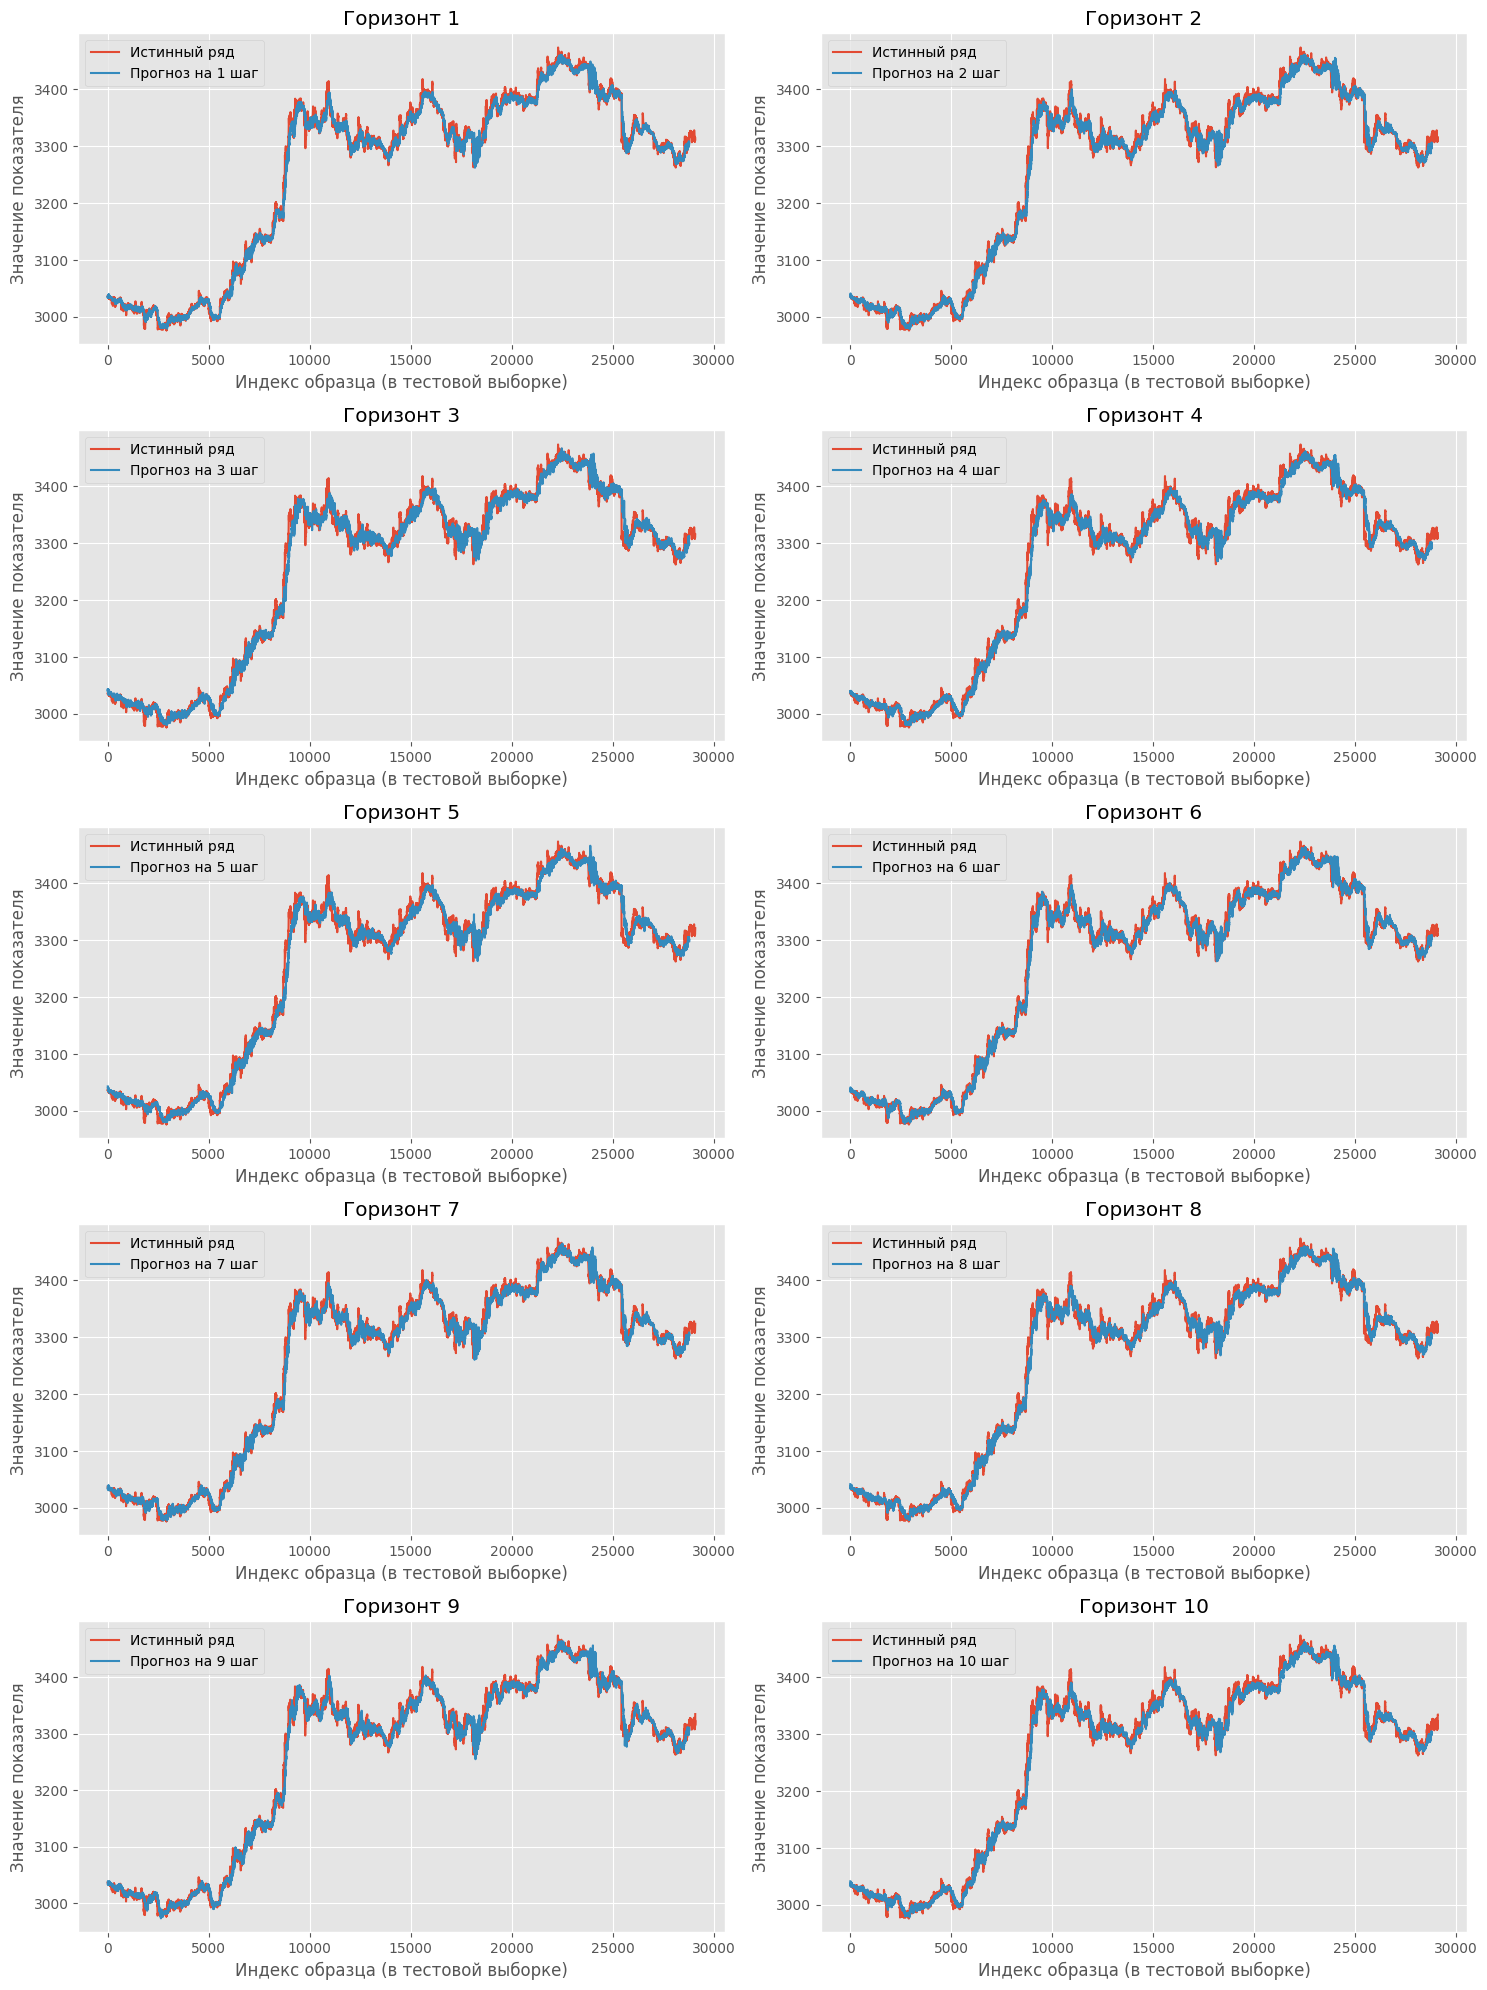

In [ ]:
# Построение 10 графиков
plt.figure(figsize=(15, 20))
for h in range(FORECAST_STEPS):
    plt.subplot(5, 2, h+1)

    # Определяем соответствующий горизонт (h+1 шагов вперед)
    true_series = y_test_unscaled[:, h]
    pred_series = y_pred_unscaled[:, h]
    plt.plot(true_series, label='Истинный ряд')
    plt.plot(pred_series, label='Прогноз на {} шаг'.format(h+1))
    plt.title(f'Горизонт {h+1}')
    plt.xlabel('Индекс образца (в тестовой выборке)')
    plt.ylabel('Значение показателя')
    plt.legend()
plt.tight_layout()
plt.show()

# Создание упрощённой модели с одномерной свёрткой

Создаем последовательную модель Sequential.

- Добавляем слой Conv1D с 50 фильтрами, размером ядра 5, активацией linear и входной формой как у тестового набора.

- Далее применяем слой Flatten для преобразования 3D выхода свёртки в 2D.

- Добавляем два полносвязных слоя: первый с 10 нейронами и линейной активацией, второй — выходной слой, соответствующий количеству предсказываемых каналов.

- Компилируем и обучаем модель на 10 эпох с оптимизатором Adam и шагом обучения 0.0001.

В конце происходит визуализация результата и оценка модели через функцию train_eval_net.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 296, 50)        │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │       148,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,321 (583.29 KB)

 Trainable params: 149,321 (583.29 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 10 эпох
Epoch 1/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.0093 - val_loss: 2.8671e-05
Epoch 2/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.8509e-04 - val_loss: 9.9645e-06
Epoch 3/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 7.5123e-05 - val_loss: 5.7201e-06
Epoch 4/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 2.7290e-05 - val_loss: 2.3306e-06
Epoch 5/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.8015e-05 - val_loss: 2.1783e-06
Epoch 6/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 2.6383e-05 - val_loss: 6.8936e-06
Epoch 7/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 2.2016e-05 - val_loss: 2.0606e-05
Epoch 8/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 8.5479e-05 - val_loss: 2.4101e-06
Epoch 9/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.4726e-05 - val_loss: 2.5921e-06
Epoch 10/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 2.1325e-05 - val_loss: 2.2325e

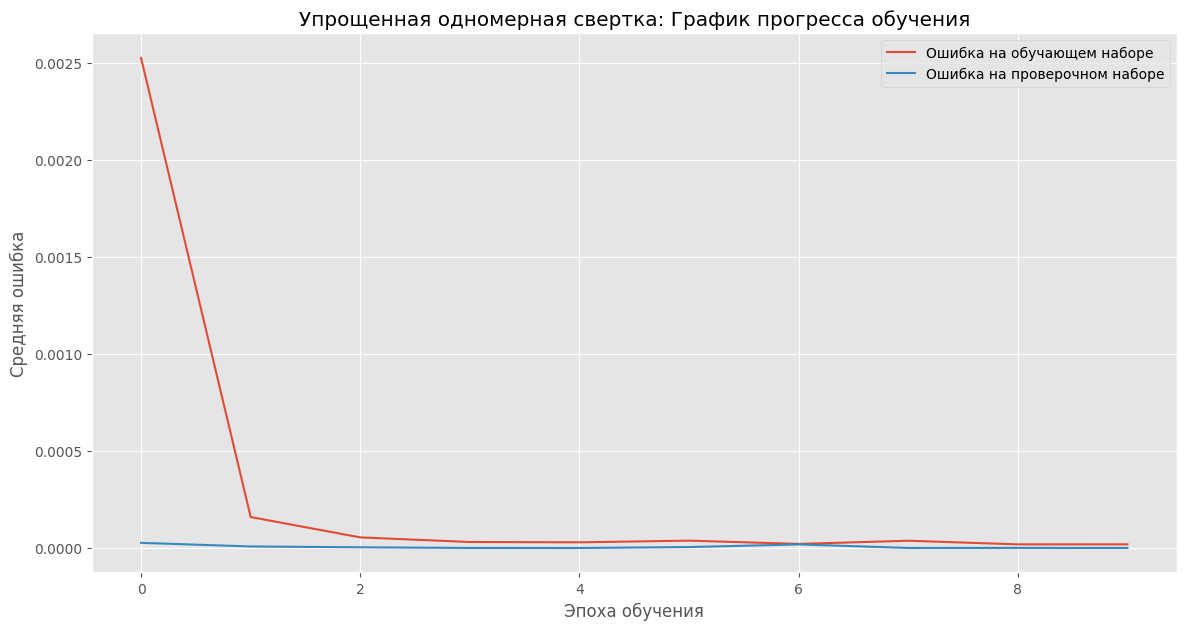

910/910 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


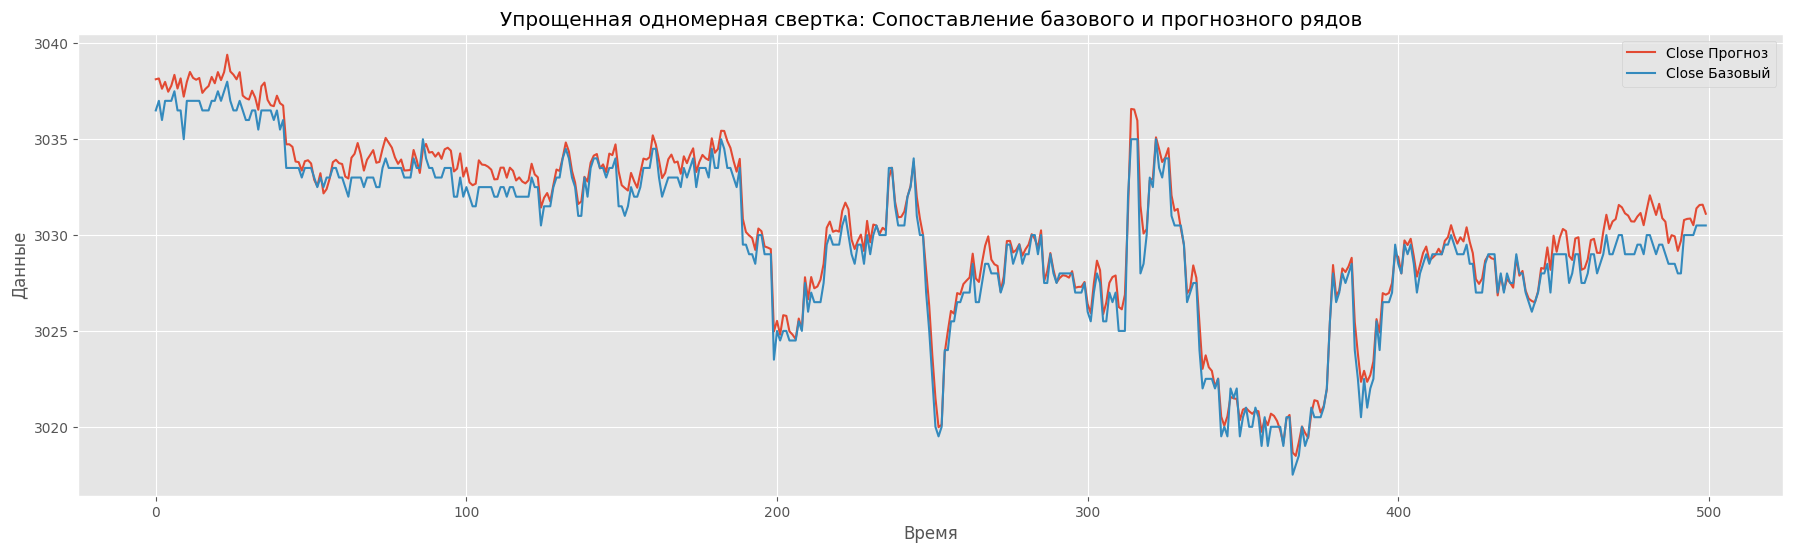

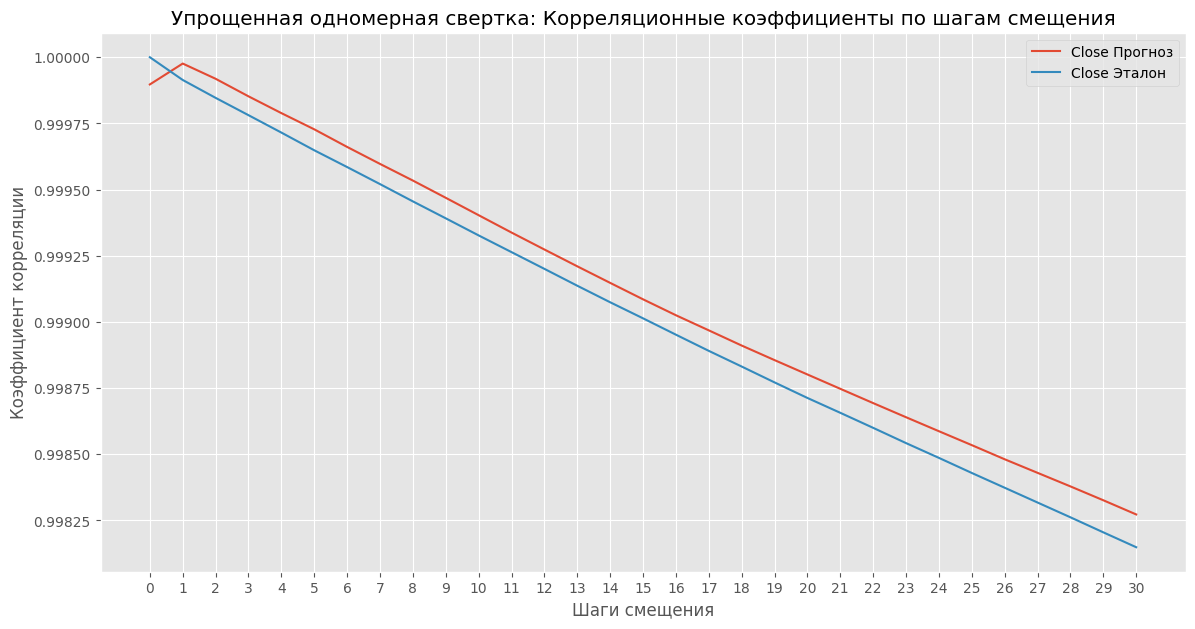

In [ ]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 10 эпох
train_eval_net(model_conv_2, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-4))],
               x_test, y_test, y_scaler, title='Упрощенная одномерная свертка')

# Модель Conv1D для предсказания 10 значений

Создается последовательная модель Sequential.

- Слой Conv1D: 50 фильтров, ядро 5, активация linear, входная форма соответствует размеру входных данных.

- Слой Flatten — преобразование в 2D.

- Полносвязный слой с 10 нейронами, активация linear.

- Выходной полносвязный слой с числом нейронов, равным FORECAST_STEPS (количество шагов прогноза), активация linear.

- Компиляция модели с оптимизатором Adam (learning_rate=1e-6) и функцией потерь MSE.

И выполняется вывод структуры модели.

In [ ]:
# Напишем сеть той же архитектуры, но для предсказания 10 будущих значений
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(FORECAST_STEPS, activation='linear'))

model_conv_2.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
model_conv_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 296, 50)        │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │       148,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,420 (583.67 KB)

 Trainable params: 149,420 (583.67 KB)

 Non-trainable params: 0 (0.00 B)

**Обучение и оценка модели с многовременным прогнозом на основе сверточной сети**

Это блок обучения модели сверточной сети (model_conv_2) с многовременным прогнозом на 10 шагов вперёд.

- Используется генератор train_datagen_multi для обучающих данных и val_datagen_multi для проверки.

- Обучение происходит в течение 10 эпох.

- Выводится подробный прогресс обучения (ошибка на обучающих и валидационных данных).

In [ ]:
# Обучение модели в течение 10 эпох (как в исходном примере)
history = model_conv_2.fit(
    train_datagen_multi,
    validation_data=val_datagen_multi,
    epochs=10,
    verbose=1
)

Epoch 1/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0275 - val_loss: 4.9852e-04
Epoch 2/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 5.6468e-04 - val_loss: 4.4529e-04
Epoch 3/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 5.2628e-04 - val_loss: 4.0840e-04
Epoch 4/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 5.3355e-04 - val_loss: 3.8384e-04
Epoch 5/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 5.2391e-04 - val_loss: 3.8688e-04
Epoch 6/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 5.1912e-04 - val_loss: 4.0297e-04
Epoch 7/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 5.0304e-04 - val_loss: 4.0451e-04
Epoch 8/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 5.0151e-04 - val_loss: 3.7176e-04
Epoch 9/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 4.8156e-04 - val_loss: 3.8127e-04
Epoch 10/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 4.9120e-04 - val_loss: 3.9067e-04


**Визуализация результатов**

С помощью функции get_pred получаем денормализованные предсказания y_pred и истинные значения y_true на тестовой выборке.

Отрисовка графика сравнения - визуализируем прогноз и оригинальный временной ряд на одном графике с помощью функции show_predict. Для многошагового прогноза отображаются сразу все шаги вперёд без сдвига.

Корреляционный анализ - строим график корреляционных коэффициентов между прогнозом и эталоном по разным сдвигам во времени с помощью функции show_corr.

910/910 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


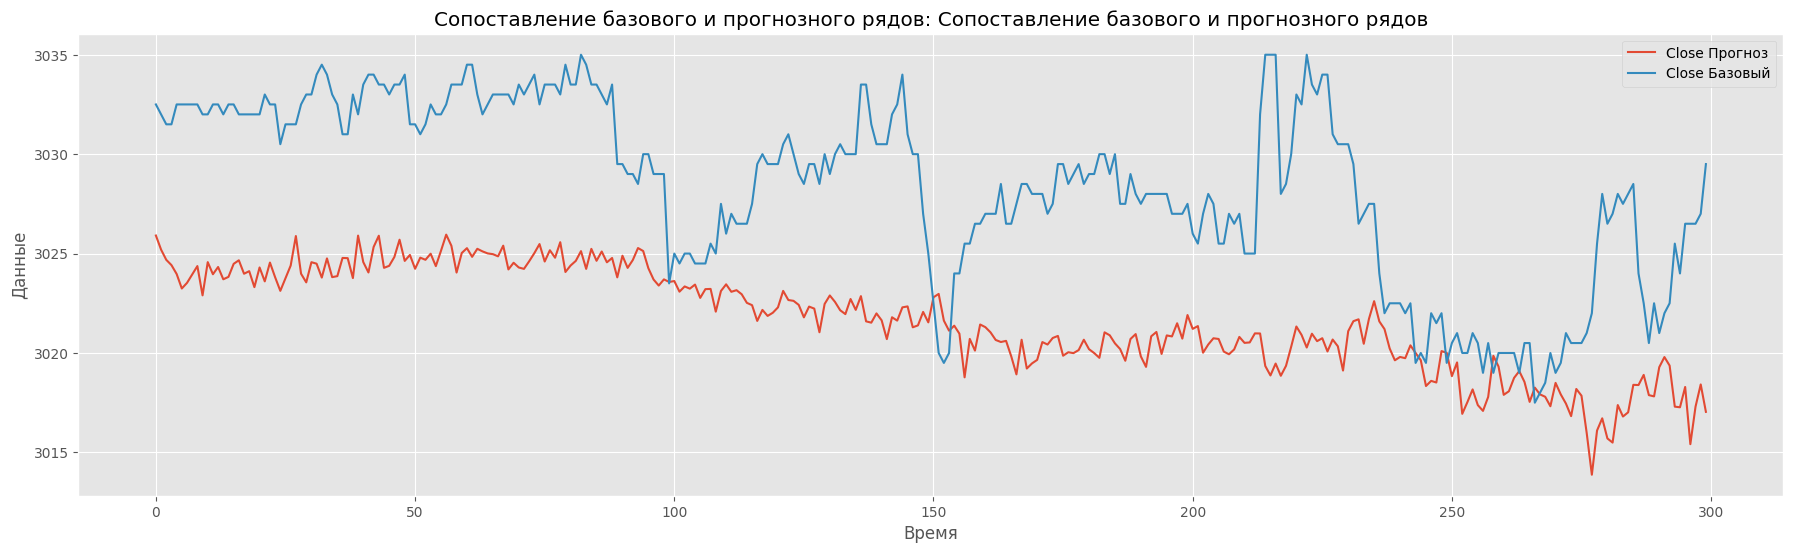

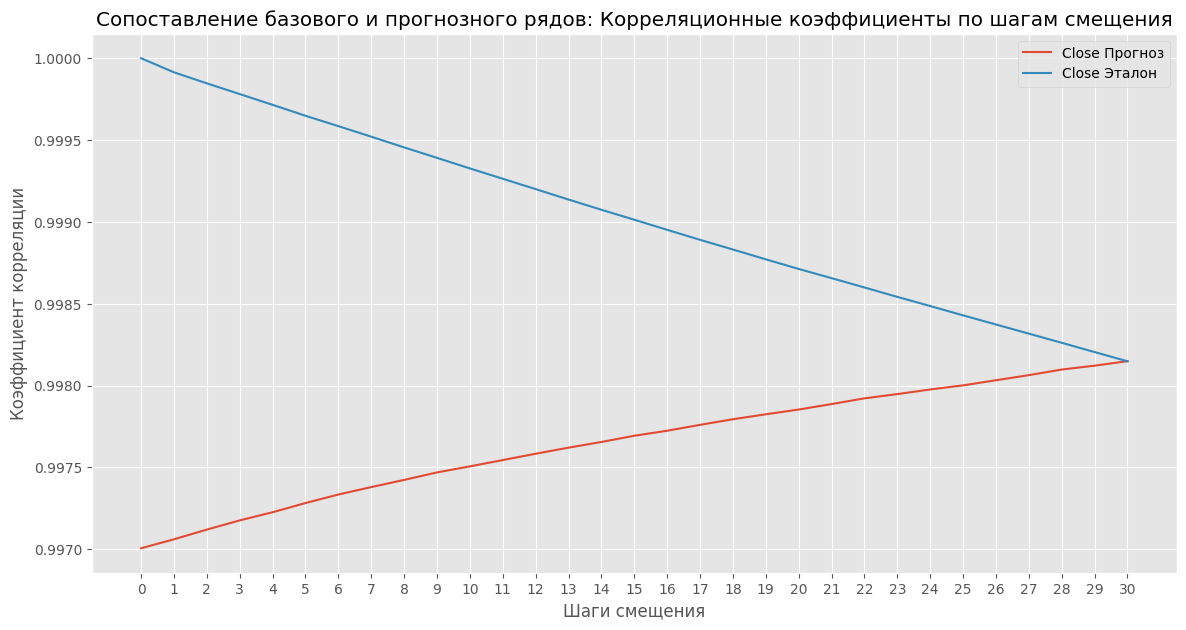

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_conv_2, x_test, y_test, y_scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
# Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
title = 'Сопоставление базового и прогнозного рядов'
show_predict(y_pred[1:], y_true[:-1], start, length, title=f'{title}: Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, back_steps_max=30, title=f'{title}: Корреляционные коэффициенты по шагам смещения')

**Получение предсказаний**

- Получаем предсказания модели на тестовой выборке в нормализованном виде (y_pred_scaled) с формой (число примеров, 10 шагов вперёд).

- Для обратного масштабирования с помощью y_scaler данные преобразуются в двумерный формат с одной колонкой:

- y_pred_scaled и y_test_multi раскладываются в столбцы (reshape(-1, 1)).

- Выполняется обратное преобразование масштаба (inverse_transform), после чего данные возвращаются к исходной форме с 10 шагами на пример.

В итоге получаем денормализованные предсказания y_pred_unscaled и истинные значения y_test_unscaled для последующего анализа и визуализации.

In [ ]:
# Получение предсказаний на тестовой выборке (в масштабе [0,1])
y_pred_scaled = model_conv_2.predict(test_datagen_multi)  # форма (N, 10)

# Преобразование предсказаний и правильных ответов обратно в исходный масштаб
# Для использования scaler необходимо подать данные в двумерном формате
y_pred_reshaped = y_pred_scaled.reshape(-1, 1)              # раскладываем все 10 шагов в одну колонку
y_test_reshaped = y_test_multi.reshape(-1, 1)               # аналогично раскладываем истинные значения

y_pred_unscaled = y_scaler.inverse_transform(y_pred_reshaped).reshape(-1, FORECAST_STEPS)
y_test_unscaled = y_scaler.inverse_transform(y_test_reshaped).reshape(-1, FORECAST_STEPS)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


**Построение графиков для каждого из 10 шагов прогноза**

- Создаем фигуру с размерами (15, 20) дюймов для удобного отображения.

- В цикле for строим 10 подграфиков (по 5 в столбик и 2 в строку).

- Для каждого шага прогноза (h от 0 до 9):

- Берем соответствующие истинные и предсказанные значения.

- Строим линию истинного ряда и линию прогноза.

- Добавляем заголовок с номером шага, подписи осей и легенду.

- Используем tight_layout() для аккуратного расположения графиков.

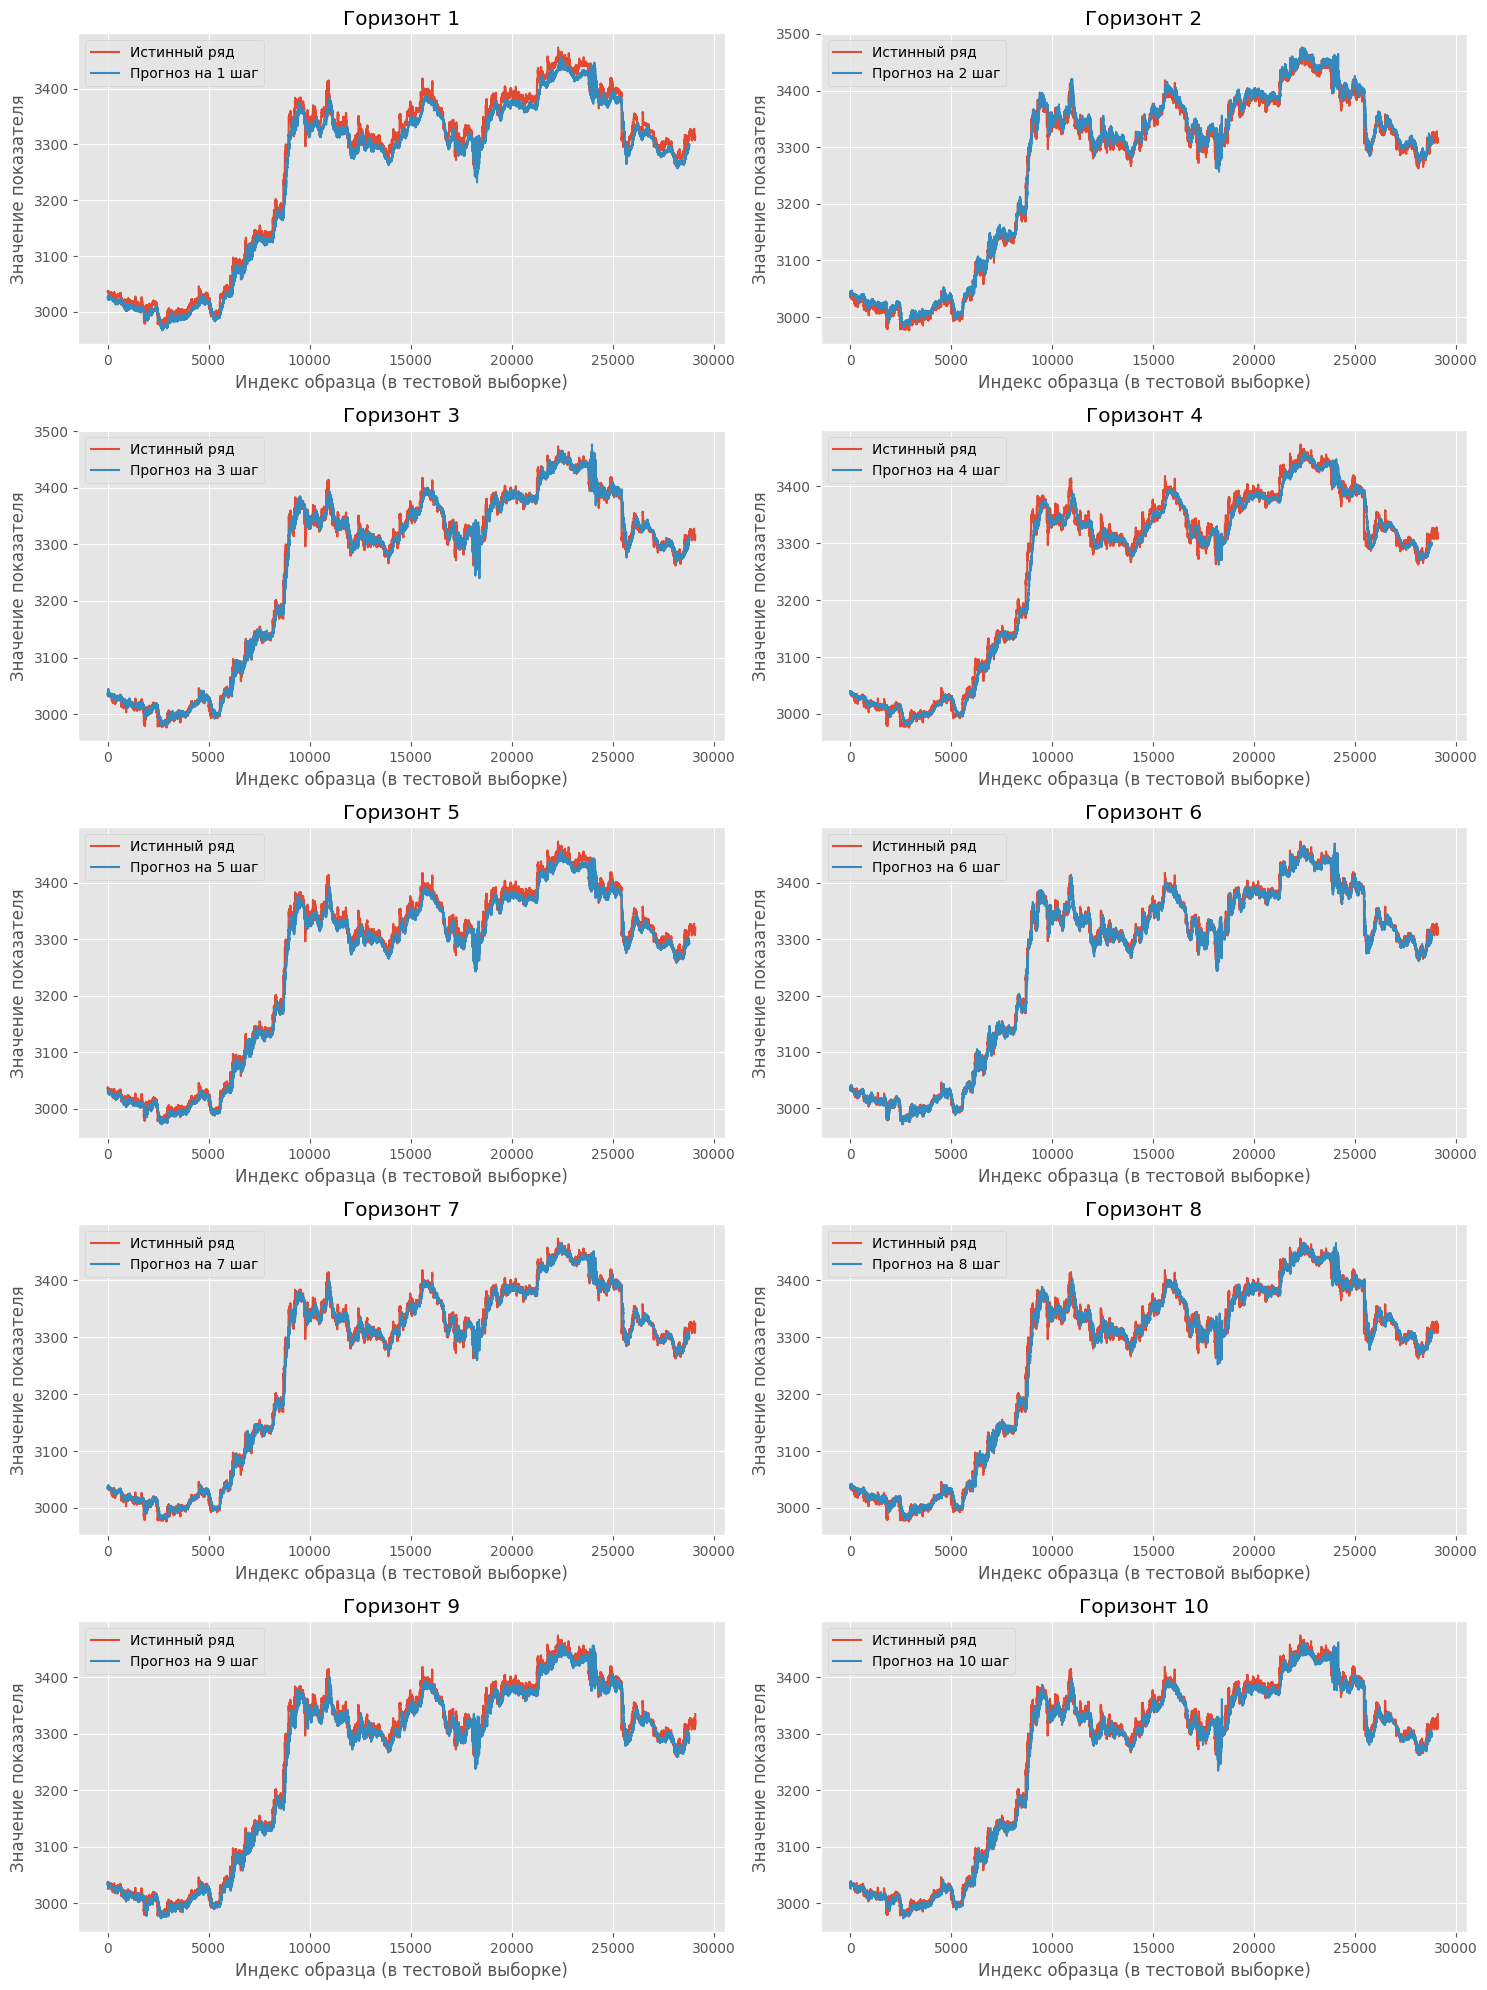

In [ ]:
# Построение 10 графиков
plt.figure(figsize=(15, 20))
for h in range(FORECAST_STEPS):
    plt.subplot(5, 2, h+1)  # размещаем графики в сетке 5x2
    # Определяем соответствующий горизонт (h+1 шагов вперед)
    true_series = y_test_unscaled[:, h]
    pred_series = y_pred_unscaled[:, h]
    plt.plot(true_series, label='Истинный ряд')
    plt.plot(pred_series, label='Прогноз на {} шаг'.format(h+1))
    plt.title(f'Горизонт {h+1}')
    plt.xlabel('Индекс образца (в тестовой выборке)')
    plt.ylabel('Значение показателя')
    plt.legend()
plt.tight_layout()
plt.show()

# Вывод по заданию

В ходе работы была обучена простая полносвязная нейросеть для одноступенчатого прогноза временного ряда цены закрытия акций Лукойла. Модель показала приемлемое качество предсказания, что подтверждается визуализацией, где прогнозная линия хорошо совпадает с исходными данными, отражая основные тенденции и колебания временного ряда.

Далее была расширена та же архитектура для прямого многошагового прогноза на 10 шагов вперед. Обучение прошло успешно, и для каждого горизонта прогноза были построены отдельные графики, что позволило наглядно оценить снижение точности с ростом числа шагов прогнозирования.

Также было проведено обучение и оценка модели с использованием одномерных свёрточных слоев (Conv1D). Эта архитектура показала хорошую способность захватывать локальные паттерны во временных данных, обеспечивая конкурентоспособные результаты и для одноступенчатого, и для многошагового прогноза. Визуализация подтвердила, что Conv1D-сети могут быть более эффективными в задачах анализа временных рядов, чем простые полносвязные сети.
